In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
path = '/content/drive/MyDrive/Colab Notebooks/Retail/data/'

In [ ]:
%%time
df = pd.read_parquet(path + "df_preprocessed.parquet")

CPU times: user 5.9 s, sys: 2.8 s, total: 8.69 s
Wall time: 8.72 s


In [ ]:
df

,PLU_CD,GDS_NM,SALE_QTY,SALE_PRC,SALE_AMT,SCALES_GDS_TP_NM,mart_name,log_dt,cate_id,month,weekday,hour
9206184,8891318877796,주사위캔디,2.000,1000.000,2000.000,일반,B마트,2022-07-09 19:42:35,NaN,7,5,19
370470,8801117122003,오리온 초코칩쿠키,2.000,1980.000,3600.000,일반,A마트,2022-03-08 14:30:27,NaN,3,1,14
22576269,201181,무우,1.000,4200.000,4200.000,일반저울,P마트,2022-09-17 16:14:50,86.000,9,5,16
14761906,8801007243054,CJ)쇠고기다시다,1.000,2700.000,2700.000,일반,G마트,2021-12-17 11:44:48,NaN,12,4,11
5103200,2908990004337,적상추 1봉/비닐,1.000,1000.000,1000.000,일반,A마트,2022-04-24 13:26:33,NaN,4,6,13
...,...,...,...,...,...,...,...,...,...,...,...,...
16177261,22002518,깻잎,1.000,1480.000,1480.000,일반,H마트,2022-05-27 13:07:35,57.000,5,4,13
21765736,8801045290300,오뚜기)3분카레순한맛(1인분),2.000,1500.000,3000.000,일반,N마트,2022-05-18 19:21:13,NaN,5,2,19
6002690,8805194003187,맛고을호박제리,1.000,2900.000,2900.000,일반,A마트,2021-10-07 12:01:12,NaN,10,3,12
14027828,8809280980215,꿀부사,1.000,9900.000,9900.000,일반,F마트,2022-01-06 18:08:46,0.000,1,3,18


In [ ]:
cate_df = pd.read_parquet(path+"category_map.parquet")

In [ ]:
cate_raw = pd.read_excel(path+"리테일_카테고리_분류.xlsx")
cate_raw = cate_raw[["대", "소"]].drop_duplicates()
cate_raw = cate_raw.assign(cate_id = range(len(cate_raw)))    

In [ ]:
cate_raw["소"] = cate_raw["소"].fillna("미분류")

In [ ]:
# df["GDS_NM"] = df["GDS_NM"].str.replace(pat=r'[^\w]', repl=r'', regex=True)

In [ ]:
df = df.sample(frac=0.05)

In [ ]:
print(df.cate_id.isna().sum()/len(df.cate_id)*100)

88.57223228256474


In [ ]:
## 현재 확인
print(f"카테고리 커버리지: {df.cate_id.notna().mean()*100:.2f}%")

sale_coverage = df.loc[df.cate_id.notna(), "SALE_AMT"].sum() / df.SALE_AMT.sum()
print(f"매출액 커버리지: {sale_coverage*100:.2f}%")

sale_qty_coverage = df.loc[df.cate_id.notna(), "SALE_QTY"].sum() / df.SALE_QTY.sum()
print(f"판매량 커버리지: {sale_qty_coverage*100:.2f}%")

카테고리 커버리지: 11.43%
매출액 커버리지: 10.84%
판매량 커버리지: 10.09%


### 기본 전처리

In [ ]:
df = df.assign(
    month = df.log_dt.dt.month,
    weekday = df.log_dt.dt.weekday,
    hour = df.log_dt.dt.hour
)

### 정답지

In [ ]:
df_answer = df[df.cate_id.notna()]

In [ ]:
df_answer

,PLU_CD,GDS_NM,SALE_QTY,SALE_PRC,SALE_AMT,SCALES_GDS_TP_NM,mart_name,log_dt,cate_id,month,weekday,hour
22576269,201181,무우,1.000,4200.000,4200.000,일반저울,P마트,2022-09-17 16:14:50,86.000,9,5,16
16517087,23000391,햇무우,1.000,1450.000,1450.000,일반,H마트,2022-03-29 17:57:17,86.000,3,1,17
18725623,204221,오징어,1.000,20000.000,20000.000,일반저울,I마트,2021-09-03 14:10:46,267.000,9,4,14
20809939,201068,청피망,1.000,2000.000,2000.000,일반저울,M마트,2021-11-04 13:54:02,100.000,11,3,13
2643126,201488,골드키위,1.000,8000.000,8000.000,일반저울,A마트,2022-07-14 13:12:22,15.000,7,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...
19625957,8809292783514,자연의선아삭한숙주,1.000,1680.000,1680.000,일반,I마트,2021-09-17 12:12:07,141.000,9,4,12
19849279,2000040,부추,1.000,2980.000,2980.000,일반저울,J마트,2022-07-17 18:12:10,53.000,7,6,18
272255,8801582920067,쌀소성주,2.000,1250.000,2500.000,일반,A마트,2021-10-09 16:48:24,426.000,10,5,16
16177261,22002518,깻잎,1.000,1480.000,1480.000,일반,H마트,2022-05-27 13:07:35,57.000,5,4,13


In [ ]:
assert df_answer.groupby("GDS_NM").cate_id.nunique().max() == 1

In [ ]:
df.groupby(["mart_name", "GDS_NM"]).SALE_AMT.sum()

mart_name  GDS_NM            
A마트         조미오징어다리(장족)          4850.000
           (안)홈스타 락스와세제 후로랄파인    3580.000
           (행사)다시멸치 박스           4980.000
           (현미)찰고추장             38360.000
           *(경산)샤인머스켓/2kg/1박스   24800.000
                                   ...   
P마트        해태)평창수 2L              900.000
           햇감자                  16060.000
           햇반컵반(빅)치킨마요덮밥         3980.000
           호박고구마                 7190.000
           후레쉬 영양란(10구)          4600.000
Name: SALE_AMT, Length: 7189, dtype: float64

### 정답에서 정답 만들기

In [ ]:
sorted(df.log_dt.dt.hour.unique())

In [ ]:
group_sale = df_answer.groupby(["mart_name", "GDS_NM"]).SALE_AMT.sum()
group_sale = group_sale.sort_values(ascending=False)

In [ ]:
group_sale

mart_name  GDS_NM
L마트        제스프리      3024800.0
A마트        감자        1373960.0
H마트        하우스딸기     1289540.0
A마트        양념닭갈비     1154510.0
F마트        딸기        1040620.0
                       ...    
H마트        미역줄기          990.0
N마트        파채            990.0
A마트        쥬키니호박         980.0
J마트        치커리           900.0
G마트        양파            560.0
Name: SALE_AMT, Length: 1916, dtype: float64

In [ ]:
def candidate_generation(cate_raw, gds_nm):

    raw_name_cover = cate_raw[cate_raw["소"].str.contains(gds_nm)]
    target_name_cover = cate_raw[cate_raw["소"].apply(lambda x: x in gds_nm)]
    
    cand_df = pd.concat([raw_name_cover, target_name_cover]).drop_duplicates()
    return cand_df 

In [ ]:
def simple_jaccard_sim(word1, word2):
    s1 = set(word1)
    
    s2 = set(word2)
    return len(s1 & s2) / len(s1 | s2)

In [ ]:
df.PLU_CD.value_counts()

2908990008649    2308
2908990006331    1061
22001375         1025
290000000018      917
8801115114154     887
                 ... 
8809643045360       1
8801007916521       1
8801052090719       1
8801051086676       1
8801046328354       1
Name: PLU_CD, Length: 21428, dtype: int64

In [ ]:
(df.PLU_CD.astype(str).str[:3]=='880').mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of 9771473     False
6245260      True
11704603     True
9665701      True
4651603      True
            ...  
10975728     True
6687048      True
12354126     True
5316486     False
677418      False
Name: PLU_CD, Length: 227516, dtype: bool>

In [ ]:
# 공산품
(df.PLU_CD.astype(str).str[:3] == '880').mean()*100

63.66365442430423

In [ ]:
# 신선식품으로 추정
(df.PLU_CD.astype(str).str[0] == '2').mean()*100

31.092318781975774

In [ ]:
# 수입
(df.PLU_CD.astype(str).str[0] == '9').mean()*100

0.07603860827370383

In [ ]:
def _feature_generator(df):
    feature_dict = {}

    is_imported = (df.PLU_CD.astype(str).str[0] == '9').mean()
    is_factory = (df.PLU_CD.astype(str).str[:3] == '880').mean()

    feature_dict["is_imported"] = is_imported

    feature_dict["is_factory"] = is_factory

    hour_count = df.hour.value_counts(normalize=True).sort_index()
    hour_count.index = [f"hourly_sale_ratio_{i}" for i in hour_count.index]
    feature_dict.update(hour_count.to_dict())

    feature_dict["sale_prc_mean"] = df.SALE_PRC.mean()
    feature_dict["sale_prc_median"] = df.SALE_PRC.median()
    
    return feature_dict

In [ ]:
def cand_info_generator(cand_df, mart_name, gds_nm):
    cand_dict = {}
    for _, row in cand_df.iterrows():
        cand_dict[row.cate_id] = {
            "tran": df[
                        (df.cate_id == row.cate_id) &
                        (df.mart_name != mart_name)
                    ],
            "name_sim":simple_jaccard_sim(row["소"], gds_nm),
            "label":group.cate_id.values[0] == row["cate_id"]
        }
    return cand_dict

def feature_generator(group, cand_dict):
    res = []
    group_feature = _feature_generator(group)
    group_feature = pd.Series(group_feature).to_frame().T
    group_feature.index = ["group"]
    group_feature = group_feature.rename(columns={col:f"{col}_group" for col in group_feature})

    for cand_id, cand_info in cand_dict.items():
        cand_df = cand_info["tran"]
        cand_feature = pd.Series(_feature_generator(cand_df)).to_frame().T
        cand_feature.index = [cand_id]

        cand_feature = cand_feature.rename(columns={col:f"{col}_cand" for col in group_feature})

        feature_row = pd.concat([group_feature.reset_index(drop=True), cand_feature.reset_index(drop=True)], axis=1)

        feature_row = feature_row.assign(
            name_sim = cand_info["name_sim"], 
            label = cand_info["label"]
        )

        res.append(feature_row)
        
    feature_df = pd.concat(res)
    return feature_df


In [ ]:
cnt = 0
res = []
for (mart_name, gds_nm), sale_amt in tqdm(group_sale.iteritems(), total=len(group_sale)):

    group = df[
        (df.mart_name == mart_name) &
        (df.GDS_NM == gds_nm)
    ]

    cate_id = group.cate_id.values[0]
    cand_df = candidate_generation(cate_raw, gds_nm)
    if len(cand_df) == 0:
        continue
    
    cand_dict = cand_info_generator(cand_df, mart_name, gds_nm)
    feature_df_temp = feature_generator(group, cand_dict)
    res.append(feature_df_temp)

    
#     cnt += 1
#     if cnt > 100:
#         break

100%|██████████| 1916/1916 [01:49<00:00, 17.42it/s]


In [ ]:
feature_df = pd.concat(res)

In [ ]:
feature_df.label.value_counts()

True     1437
False     953
Name: label, dtype: int64

### Postprocess

In [ ]:
hour_cols = [col for col in feature_df.columns if "hour" in col]
sale_cols = [col for col in feature_df.columns if "sale" in col]
bool_cols = [col for col in feature_df.columns if "is_" in col]

In [ ]:
assert set(feature_df.columns) == set(hour_cols + sale_cols + bool_cols + ["label", "name_sim"])

In [ ]:
hour_cols = sorted(hour_cols)
sale_cols = sorted(sale_cols)

In [ ]:
# 이 부분때문에 column이 중복되는거 같음
# feature_df = feature_df[hour_cols + sale_cols + bool_cols + ["name_sim", "label"]]

In [ ]:
# feature_df = feature_df.drop_duplicates()

In [ ]:
feature_df =feature_df.fillna(0)

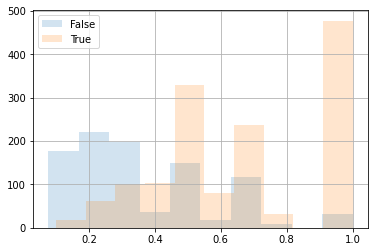

In [ ]:
leg = []
for label, group in feature_df.groupby("label"):
    group.name_sim.hist(alpha=0.2)
    leg.append(label)
plt.legend(leg)
plt.show()

In [ ]:
pd.set_option('display.max_columns', None)
feature_df

,is_imported_group,is_fresh_group,is_factory_group,hourly_sale_ratio_8_group,hourly_sale_ratio_12_group,hourly_sale_ratio_20_group,sale_prc_mean_group,sale_prc_median_group,is_imported,is_fresh,is_factory,sale_prc_mean,sale_prc_median,name_sim,label,hourly_sale_ratio_7_group,hourly_sale_ratio_9_group,hourly_sale_ratio_10_group,hourly_sale_ratio_11_group,hourly_sale_ratio_13_group,hourly_sale_ratio_14_group,hourly_sale_ratio_15_group,hourly_sale_ratio_16_group,hourly_sale_ratio_17_group,hourly_sale_ratio_18_group,hourly_sale_ratio_19_group,hourly_sale_ratio_21_group,hourly_sale_ratio_2,hourly_sale_ratio_8,hourly_sale_ratio_9,hourly_sale_ratio_10,hourly_sale_ratio_11,hourly_sale_ratio_12,hourly_sale_ratio_13,hourly_sale_ratio_14,hourly_sale_ratio_15,hourly_sale_ratio_16,hourly_sale_ratio_17,hourly_sale_ratio_18,hourly_sale_ratio_19,hourly_sale_ratio_20,hourly_sale_ratio_21,hourly_sale_ratio_22,hourly_sale_ratio_23,hourly_sale_ratio_22_group,hourly_sale_ratio_4,hourly_sale_ratio_7,hourly_sale_ratio_6,hourly_sale_ratio_1,hourly_sale_ratio_5,hourly_sale_ratio_23_group,hourly_sale_ratio_1_group,hourly_sale_ratio_6_group,hourly_sale_ratio_2_group,hourly_sale_ratio_5_group,hourly_sale_ratio_4_group
0,0.0,1.0,0.0,0.333333,0.333333,0.333333,1.008267e+06,15000.0,0.0,0.000000,0.000000,0.000000,0.0,0.500000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,1.0,0.0,0.011521,0.064516,0.048387,3.161198e+03,2530.0,0.0,0.936620,0.063380,3302.235915,2715.0,1.000000,True,0.002304,0.036866,0.050691,0.082949,0.076037,0.103687,0.09447,0.112903,0.115207,0.133641,0.050691,0.016129,0.001761,0.007042,0.042254,0.066901,0.061620,0.079225,0.066901,0.065141,0.119718,0.116197,0.123239,0.093310,0.079225,0.036972,0.028169,0.012324,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,1.0,0.0,0.011521,0.064516,0.048387,3.161198e+03,2530.0,0.0,0.000000,0.000000,0.000000,0.0,0.333333,False,0.002304,0.036866,0.050691,0.082949,0.076037,0.103687,0.09447,0.112903,0.115207,0.133641,0.050691,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,1.0,0.0,0.011521,0.064516,0.048387,3.161198e+03,2530.0,0.0,0.000000,0.000000,0.000000,0.0,0.500000,False,0.002304,0.036866,0.050691,0.082949,0.076037,0.103687,0.09447,0.112903,0.115207,0.133641,0.050691,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,1.0,0.0,0.011521,0.064516,0.048387,3.161198e+03,2530.0,0.0,0.986957,0.013043,7687.434783,6900.0,0.500000,False,0.002304,0.036866,0.050691,0.082949,0.076037,0.103687,0.09447,0.112903,0.115207,0.133641,0.050691,0.016129,0.000000,0.004348,0.021739,0.052174,0.069565,0.043478,0.052174,0.065217,0.108696,0.117391,0.139130,0.100000,0.095652,0.060870,0.047826,0.021739,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,1.0,0.0,0.000000,0.000000,0.000000,9.900000e+02,990.0,0.0,0.833946,0.047024,2618.449669,1980.0,0.500000,True,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000735,0.009552,0.037472,0.067597,0.069067,0.065393,0.059515,0.076414,0.093314,0.117561,0.124173,0.110948,0.085231,0.042616,0.027186,0.005878,0.002204,0.0,0.000735,0.004409,0.0,0.0,

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
# pd.reset_option('display.float_format')
feature_df.sale_prc_mean_group

0   1008266.667
0      3161.198
0      3161.198
0      3161.198
0      3161.198
        ...    
0       990.000
0       980.000
0       900.000
0       560.000
0       560.000
Name: sale_prc_mean_group, Length: 2390, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score


In [ ]:
X=feature_df.drop(columns=['label'],axis=1)
y=feature_df['label']

In [ ]:
lgbm=LGBMClassifier()

In [ ]:
stratifiedkfold=StratifiedKFold(n_splits=5)

acc = 0

for train_idx, valid_idx in stratifiedkfold.split(X,y):
  train_data=feature_df.iloc[train_idx]
  valid_data=feature_df.iloc[valid_idx]


  train_X=train_data.drop(columns=['label'],axis=1)
  train_y=train_data['label']


  valid_X=valid_data.drop(columns=['label'],axis=1)
  valid_y=valid_data['label']


  lgbm_model=LGBMClassifier()
  lgbm_model.fit(train_X,train_y)


  pred=lgbm_model.predict(valid_X)
  score=accuracy_score(pred, valid_y)
  print('valid 점수 : ',score)
  acc +=score
  
print('total score : ',acc/5)

valid 점수 :  0.8807531380753139
valid 점수 :  0.8891213389121339
valid 점수 :  0.9184100418410042
valid 점수 :  0.8891213389121339
valid 점수 :  0.8849372384937239
total score :  0.8924686192468618


In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bayes_opt import BayesianOptimization
from lightgbm import plot_importance

[1]	valid_0's binary_logloss: 0.613456	valid_0's binary_logloss: 0.613456
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.560681	valid_0's binary_logloss: 0.560681
[3]	valid_0's binary_logloss: 0.51379	valid_0's binary_logloss: 0.51379
[4]	valid_0's binary_logloss: 0.475608	valid_0's binary_logloss: 0.475608
[5]	valid_0's binary_logloss: 0.444952	valid_0's binary_logloss: 0.444952
[6]	valid_0's binary_logloss: 0.416431	valid_0's binary_logloss: 0.416431
[7]	valid_0's binary_logloss: 0.39246	valid_0's binary_logloss: 0.39246
[8]	valid_0's binary_logloss: 0.370984	valid_0's binary_logloss: 0.370984
[9]	valid_0's binary_logloss: 0.35251	valid_0's binary_logloss: 0.35251
[10]	valid_0's binary_logloss: 0.337276	valid_0's binary_logloss: 0.337276
[11]	valid_0's binary_logloss: 0.322473	valid_0's binary_logloss: 0.322473
[12]	valid_0's binary_logloss: 0.310032	valid_0's binary_logloss: 0.310032
[13]	valid_0's binary_logloss: 0.2978	valid_0's bina

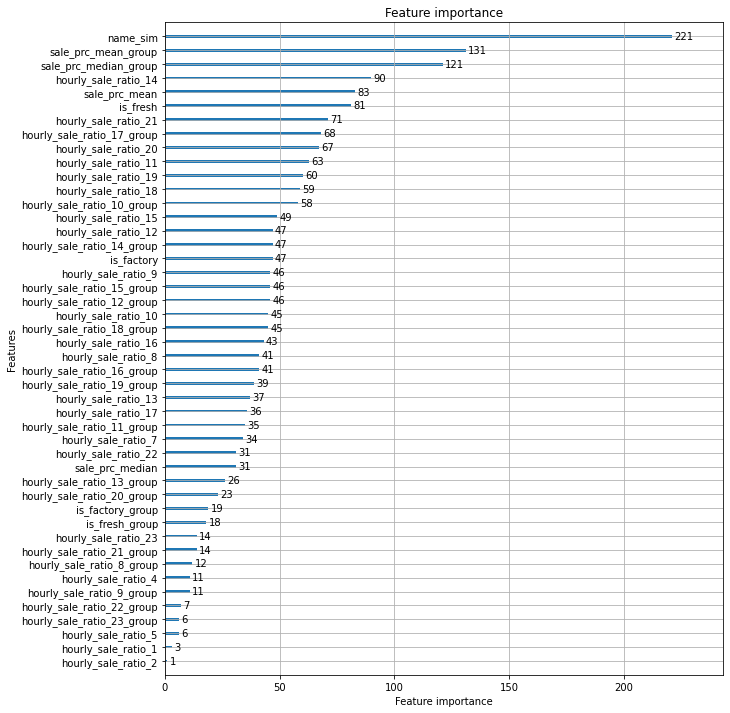

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)
lgbm_wrapper = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:1]

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()